In [ ]:
!pip install transformers datasets torch

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.0508
Epoch 2/5, Loss: 0.0380
Epoch 3/5, Loss: 0.0265
Epoch 4/5, Loss: 0.0165
Epoch 5/5, Loss: 0.0144
Model fine-tuned and saved successfully.


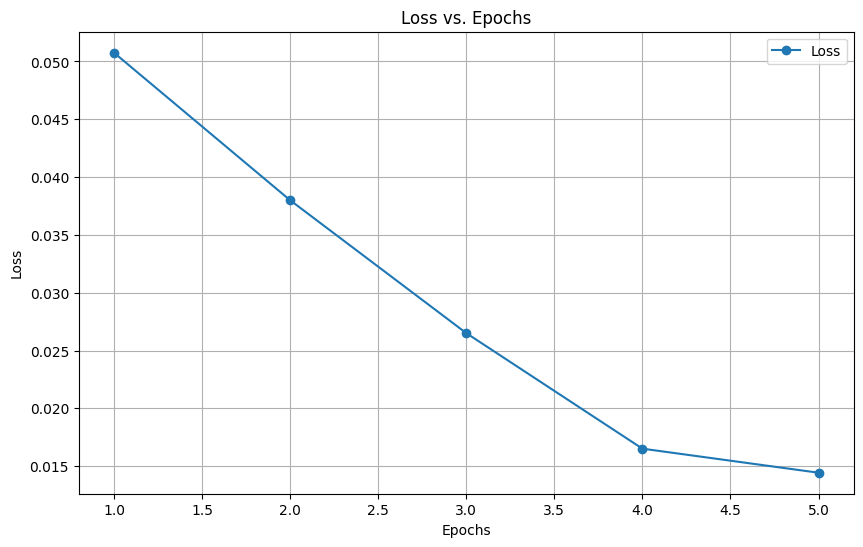

In [7]:
import json
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from transformers import DataCollatorForTokenClassification
from data import dataset
import matplotlib.pyplot as plt


class NERDataset(Dataset):
    def __init__(self, samples, tokenizer):
        self.samples = samples
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        text = sample["text"]
        entities = sample["labels"]["entities"]


        tokens = self.tokenizer.tokenize(text)
        input_ids = self.tokenizer.encode(text, add_special_tokens=True)


        labels = ['O'] * len(tokens)
        for start, end, entity_type in entities:
            start_token = len(self.tokenizer.tokenize(text[:start]))
            end_token = start_token + len(self.tokenizer.tokenize(text[start:end])) - 1
            labels[start_token] = f"B-{entity_type}"
            for i in range(start_token + 1, end_token + 1):
                labels[i] = f"I-{entity_type}"


        label_ids = [0] * len(input_ids)
        for i, label in enumerate(labels):
            if label != 'O':
                label_ids[i + 1] = 1

        return {
            'input_ids': torch.tensor(input_ids),
            'labels': torch.tensor(label_ids)
        }

def main():

    train_dataset_sample = dataset  # Access data from data.py

    #  tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    ner_dataset = NERDataset(train_dataset_sample, tokenizer)


    train_dataloader = DataLoader(ner_dataset, batch_size=2, collate_fn=DataCollatorForTokenClassification(tokenizer))


    model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=2)


    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.train()

    epoch_losses = []

    for epoch in range(5):
        total_loss = 0
        for batch in train_dataloader:
            inputs = batch['input_ids']
            labels = batch['labels']
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        avg_loss = total_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{5}, Loss: {avg_loss:.4f}")


    model.save_pretrained('fine_tuned_ner_model')
    tokenizer.save_pretrained('fine_tuned_ner_model')
    print("Model fine-tuned and saved successfully.")


    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import torch
from transformers import BertTokenizer, BertForTokenClassification


tokenizer = BertTokenizer.from_pretrained('fine_tuned_ner_model')
model = BertForTokenClassification.from_pretrained('fine_tuned_ner_model')


model.config.id2label = {0: 'O', 1: 'DEITY'}
model.config.label2id = {'O': 0, 'DEITY': 1}


def predict_entities(user_input):
    inputs = tokenizer(user_input, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2).squeeze(0).tolist()

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))
    results = [
        (token, model.config.id2label[prediction])
        for token, prediction in zip(tokens, predictions)
        if token not in ["[CLS]", "[SEP]", "[PAD]"] and model.config.id2label[prediction] != 'O'
    ]
    return results


user_input = input("Enter a sentence to extract entities: ")
entities = predict_entities(user_input)


print("\nExtracted Entities:")
if entities:
    for token, label in entities:
        print(f"Token: {token}, Label: {label}")
else:
    print("No entities found.")
    


Enter a sentence to extract entities: shiva is the god of destruction

Extracted Entities:
Token: shiva, Label: DEITY
